In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jan  7 03:23:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    57W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from PIL import Image

#Load data for U-net training
import os

#Color Channel Experimentation
import skimage
import skimage.color as scc

In [ ]:
#SIZE = 1024

In [ ]:
#Image_Dataset: MRI/Anatomical Images - Greyscale
MRI_dataset = []
image_directory = os.listdir("/content/drive/MyDrive/VCU_Lab/TBI_Sorted/Anatomical/")
image_directory = sorted(image_directory)
print(image_directory)

for i in range(len(image_directory)):
  img = cv2.imread("/content/drive/MyDrive/VCU_Lab/TBI_Sorted/Anatomical/"+image_directory[i])
  print(image_directory[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  MRI_dataset.append(img_to_array(img))

MRI_dataset = np.asarray(MRI_dataset)
print(MRI_dataset.shape)

['sub10_0.90_anatomical-001.png', 'sub10_0.92_anatomical-001.png', 'sub10_0.94_anatomical-001.png', 'sub10_0.96_anatomical-001.png', 'sub10_0.98_anatomical-001.png', 'sub10_1.00_anatomical-001.png', 'sub10_1.02_anatomical-001.png', 'sub10_1.04_anatomical-001.png', 'sub10_1.06_anatomical-001.png', 'sub10_1.08_anatomical-001.png', 'sub10_1.10_anatomical-001.png', 'sub11_0.90_anatomical-001.png', 'sub11_0.92_anatomical-001.png', 'sub11_0.94_anatomical-001.png', 'sub11_0.96_anatomical-001.png', 'sub11_0.98_anatomical-001.png', 'sub11_1.02_anatomical-001.png', 'sub11_1.04_anatomical-001.png', 'sub11_1.06_anatomical-001.png', 'sub11_1.08_anatomical-001.png', 'sub11_1.10_anatomical-001.png', 'sub12_0.90_anatomical-001.png', 'sub12_0.92_anatomical-001.png', 'sub12_0.94_anatomical-001.png', 'sub12_0.96_anatomical-001.png', 'sub12_0.98_anatomical-001.png', 'sub12_1.00_anatomical-001.png', 'sub12_1.02_anatomical-001.png', 'sub12_1.04_anatomical-001.png', 'sub12_1.06_anatomical-001.png', 'sub12_1.

In [ ]:
#Label Data Pre-processing
#Image_Dataset: E-field Images - RGB
mask_directory = os.listdir('/content/drive/MyDrive/VCU_Lab/TBI_Sorted/E_Field/')
mask_directory = sorted(mask_directory)
Efield_dataset_raw = []

for i in range(len(mask_directory)):


  img = cv2.imread("/content/drive/MyDrive/VCU_Lab/TBI_Sorted/E_Field/"+mask_directory[i])
  print(mask_directory[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  Efield_dataset_raw.append(img_to_array(img))


Efield_dataset_raw = np.asarray(Efield_dataset_raw)
print(Efield_dataset_raw.shape)

sub10_0.90_efield-001.png
sub10_0.92_efield-001.png
sub10_0.94_efield-001.png
sub10_0.96_efield-001.png
sub10_0.98_efield-001.png
sub10_1.00_efield-001.png
sub10_1.02_efield-001.png
sub10_1.04_efield-001.png
sub10_1.06_efield-001.png
sub10_1.08_efield-001.png
sub10_1.10_efield-001.png
sub11_0.90_efield-001.png
sub11_0.92_efield-001.png
sub11_0.94_efield-001.png
sub11_0.96_efield-001.png
sub11_0.98_efield-001.png
sub11_1.02_efield-001.png
sub11_1.04_efield-001.png
sub11_1.06_efield-001.png
sub11_1.08_efield-001.png
sub11_1.10_efield-001.png
sub12_0.90_efield-001.png
sub12_0.92_efield-001.png
sub12_0.94_efield-001.png
sub12_0.96_efield-001.png
sub12_0.98_efield-001.png
sub12_1.00_efield-001.png
sub12_1.02_efield-001.png
sub12_1.04_efield-001.png
sub12_1.06_efield-001.png
sub12_1.08_efield-001.png
sub12_1.10_efield-001.png
sub13_0.90_efield-001.png
sub13_0.92_efield-001.png
sub13_0.94_efield-001.png
sub13_0.96_efield-001.png
sub13_0.98_efield-001.png
sub13_1.00_efield-001.png
sub13_1.02_e

In [ ]:
#Data Normalization 
# MRI Normalization remains the same for all three sets of anatomical images
max_image = np.max(MRI_dataset)
min_image = np.min(MRI_dataset)
MRI_dataset = (MRI_dataset - min_image)/(max_image - min_image)

# E Field Normalization for RGB E-Field Images
max_mask = np.max(Efield_dataset_raw)
min_mask = np.min(Efield_dataset_raw)
Efield_dataset = (Efield_dataset_raw - min_mask)/(max_mask - min_mask)


'\n# E Field Normalization for LAB/LCH\nEfield_dataset_raw = Efield_dataset_raw/255\n'

In [ ]:
# Dataset Split
train_data, validation_data, train_mask, validation_mask  = train_test_split(MRI_dataset, Efield_dataset, test_size=0.1, random_state=1, shuffle=True)
print(train_data.shape)
print(validation_data.shape)

(108, 1024, 1024, 1)
(12, 1024, 1024, 1)


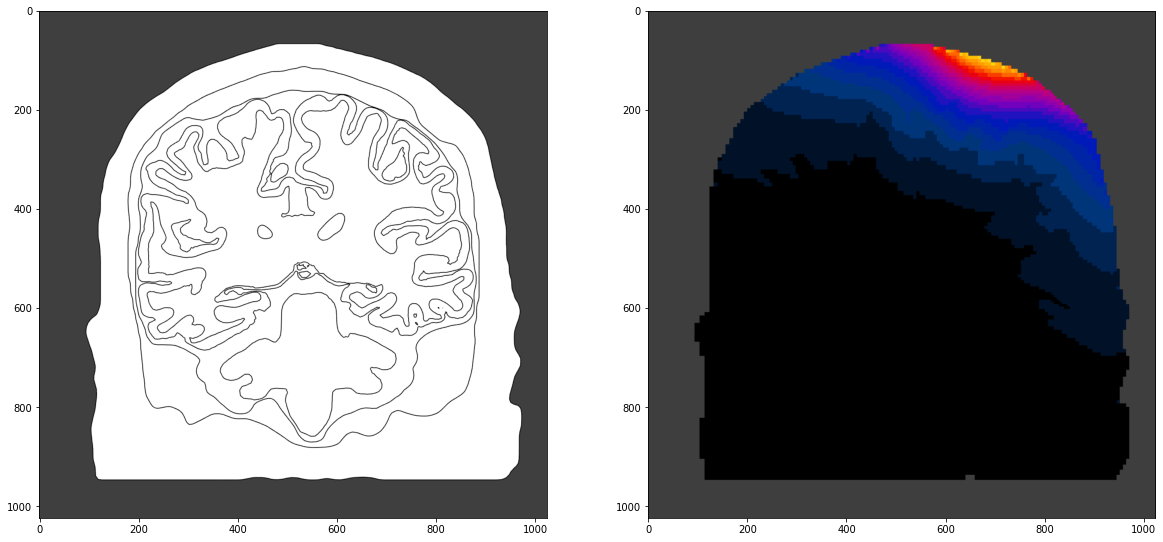

In [ ]:
#Sanity check of image-mask set
image_number = np.random.randint(0, len(train_data))
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(np.squeeze(train_data[image_number]), cmap='gray')
plt.subplot(122)
plt.imshow(np.squeeze(train_mask[image_number]), cmap='gray')
plt.show()

In [ ]:
# Training Parameters
Epoch = 200 
batch_size = 1 

input_shape = (1024, 1024, 1)
inputs = Input(shape = input_shape)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate

#Convolutional block to be used in U-Net
def conv_block(input, num_filters):
    x = Conv2D(num_filters, (3,3), padding="same")(input)
    x = BatchNormalization()(x)    
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3,3), padding="same")(x)
    x = BatchNormalization()(x)  
    x = Activation("relu")(x)

    return x

#Encoder block for U-net: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block for U-net
#skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(2*num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet_depthfive(inputs):
    s1, p1 = encoder_block(inputs, 8)
    s2, p2 = encoder_block(p1, 16)
    s3, p3 = encoder_block(p2, 32)
    s4, p4 = encoder_block(p3, 64)
    s5, p5 = encoder_block(p4, 128)

    b1 = conv_block(p5, 256) #Bridge

    d1 = decoder_block(b1, s5, 128)
    d2 = decoder_block(d1, s4, 64)
    d3 = decoder_block(d2, s3, 32)
    d4 = decoder_block(d3, s2, 16)
    d5 = decoder_block(d4, s1, 8)

    outputs = Conv2D(3, (3,3), padding="same", activation="sigmoid")(d5)  #Binary (can be multiclass)

    return outputs

Unet = Model(inputs, build_unet_depthfour(inputs))
Unet.compile(loss='mse', optimizer = Adam())
print(Unet.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 1024, 1024,   80          ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 1024,   32         ['conv2d[0][0]']                 
 alization)                     8)                                                            

In [ ]:
 #Train the model

Unet_model_history = Unet.fit(train_data, train_mask, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(validation_data, validation_mask), 
                    epochs=Epoch)

Epoch 1/200
108/108 [==============================] - 19s 48ms/step - loss: 0.0304 - val_loss: 0.0344
Epoch 2/200
108/108 [==============================] - 4s 41ms/step - loss: 0.0050 - val_loss: 0.0183
Epoch 3/200
108/108 [==============================] - 4s 41ms/step - loss: 0.0033 - val_loss: 0.0105
Epoch 4/200
108/108 [==============================] - 4s 41ms/step - loss: 0.0028 - val_loss: 0.0079
Epoch 5/200
108/108 [==============================] - 4s 41ms/step - loss: 0.0024 - val_loss: 0.0054
Epoch 6/200
108/108 [==============================] - 4s 41ms/step - loss: 0.0024 - val_loss: 0.0123
Epoch 7/200
108/108 [==============================] - 4s 41ms/step - loss: 0.0022 - val_loss: 0.0083
Epoch 8/200
108/108 [==============================] - 4s 41ms/step - loss: 0.0020 - val_loss: 0.0047
Epoch 9/200
108/108 [==============================] - 4s 41ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 10/200
108/108 [==============================] - 4s 41ms/step - loss: 0.00

{'loss': [0.03039800189435482, 0.0049501024186611176, 0.003348411526530981, 0.002810476114973426, 0.0023767496459186077, 0.002423804486170411, 0.0021673417650163174, 0.00195376412011683, 0.0017336151795461774, 0.001615033601410687, 0.0014272640692070127, 0.0014185580657795072, 0.0012753038899973035, 0.0011856965720653534, 0.0010984755354002118, 0.0010579201625660062, 0.0009775570360943675, 0.0009096190915443003, 0.0008944270084612072, 0.0008035743958316743, 0.0007868478423915803, 0.0007875000010244548, 0.0007754222024232149, 0.0007949611754156649, 0.0007764730253256857, 0.0008114236989058554, 0.0007483814842998981, 0.0006654999451711774, 0.0006657567573711276, 0.0006349491304717958, 0.0006494462722912431, 0.0006300971726886928, 0.0005934730870649219, 0.0006586555391550064, 0.0006148074171505868, 0.0006140659097582102, 0.0005809050053358078, 0.0005413523758761585, 0.0005535836098715663, 0.0005836711497977376, 0.0005586196202784777, 0.0005343272932805121, 0.0005277476157061756, 0.0005586

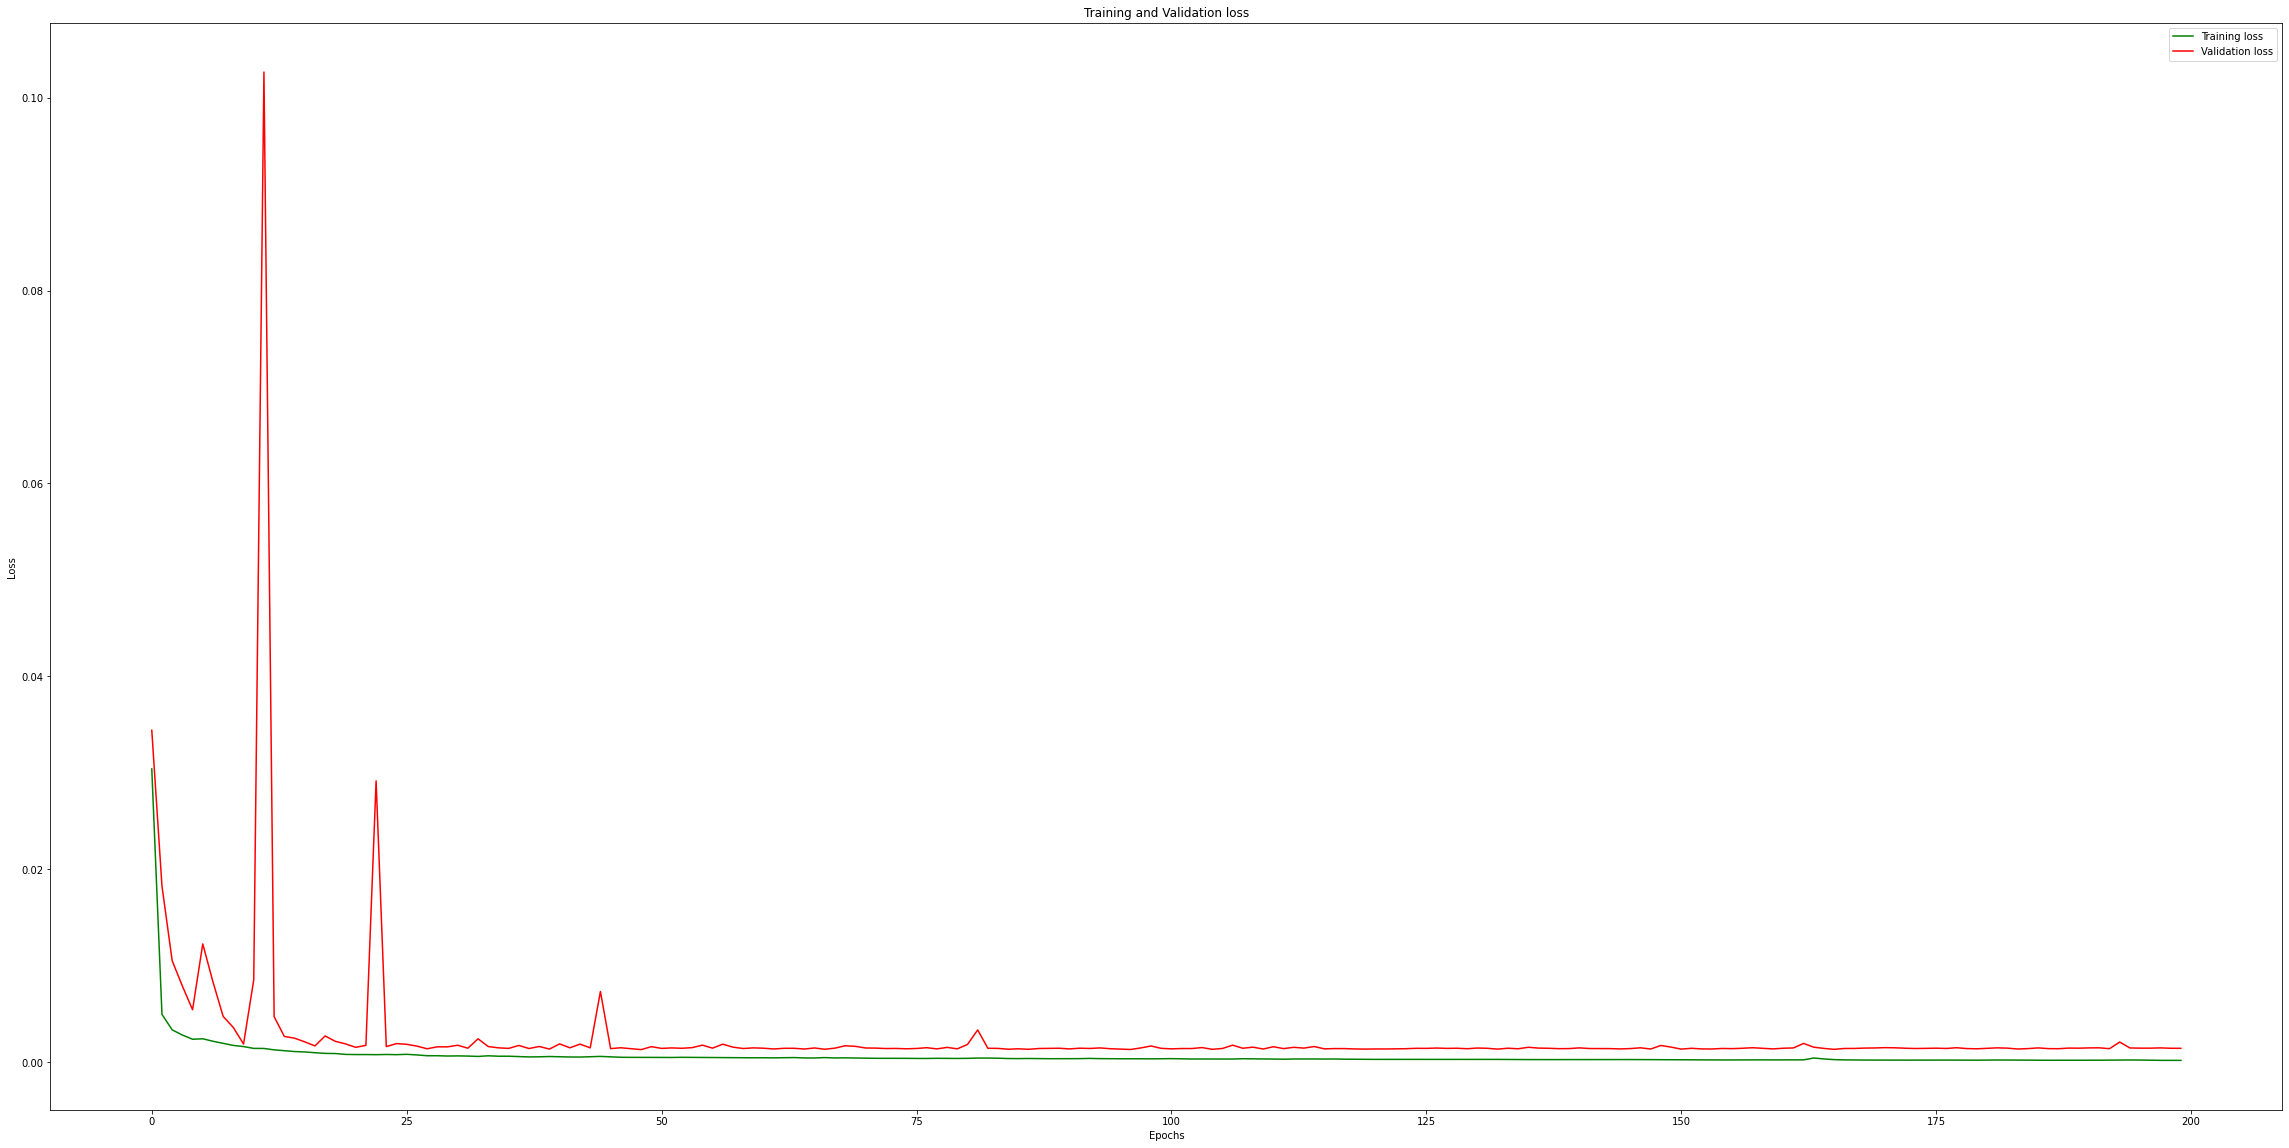

In [ ]:
#Plot the training and validation loss at each epoch
print(Unet_model_history.history)
loss = Unet_model_history.history['loss']
val_loss = Unet_model_history.history['val_loss']
epochs = range(Epoch)
plt.figure(figsize=(40, 20))
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

{'loss': [0.03039800189435482, 0.0049501024186611176, 0.003348411526530981, 0.002810476114973426, 0.0023767496459186077, 0.002423804486170411, 0.0021673417650163174, 0.00195376412011683, 0.0017336151795461774, 0.001615033601410687, 0.0014272640692070127, 0.0014185580657795072, 0.0012753038899973035, 0.0011856965720653534, 0.0010984755354002118, 0.0010579201625660062, 0.0009775570360943675, 0.0009096190915443003, 0.0008944270084612072, 0.0008035743958316743, 0.0007868478423915803, 0.0007875000010244548, 0.0007754222024232149, 0.0007949611754156649, 0.0007764730253256857, 0.0008114236989058554, 0.0007483814842998981, 0.0006654999451711774, 0.0006657567573711276, 0.0006349491304717958, 0.0006494462722912431, 0.0006300971726886928, 0.0005934730870649219, 0.0006586555391550064, 0.0006148074171505868, 0.0006140659097582102, 0.0005809050053358078, 0.0005413523758761585, 0.0005535836098715663, 0.0005836711497977376, 0.0005586196202784777, 0.0005343272932805121, 0.0005277476157061756, 0.0005586

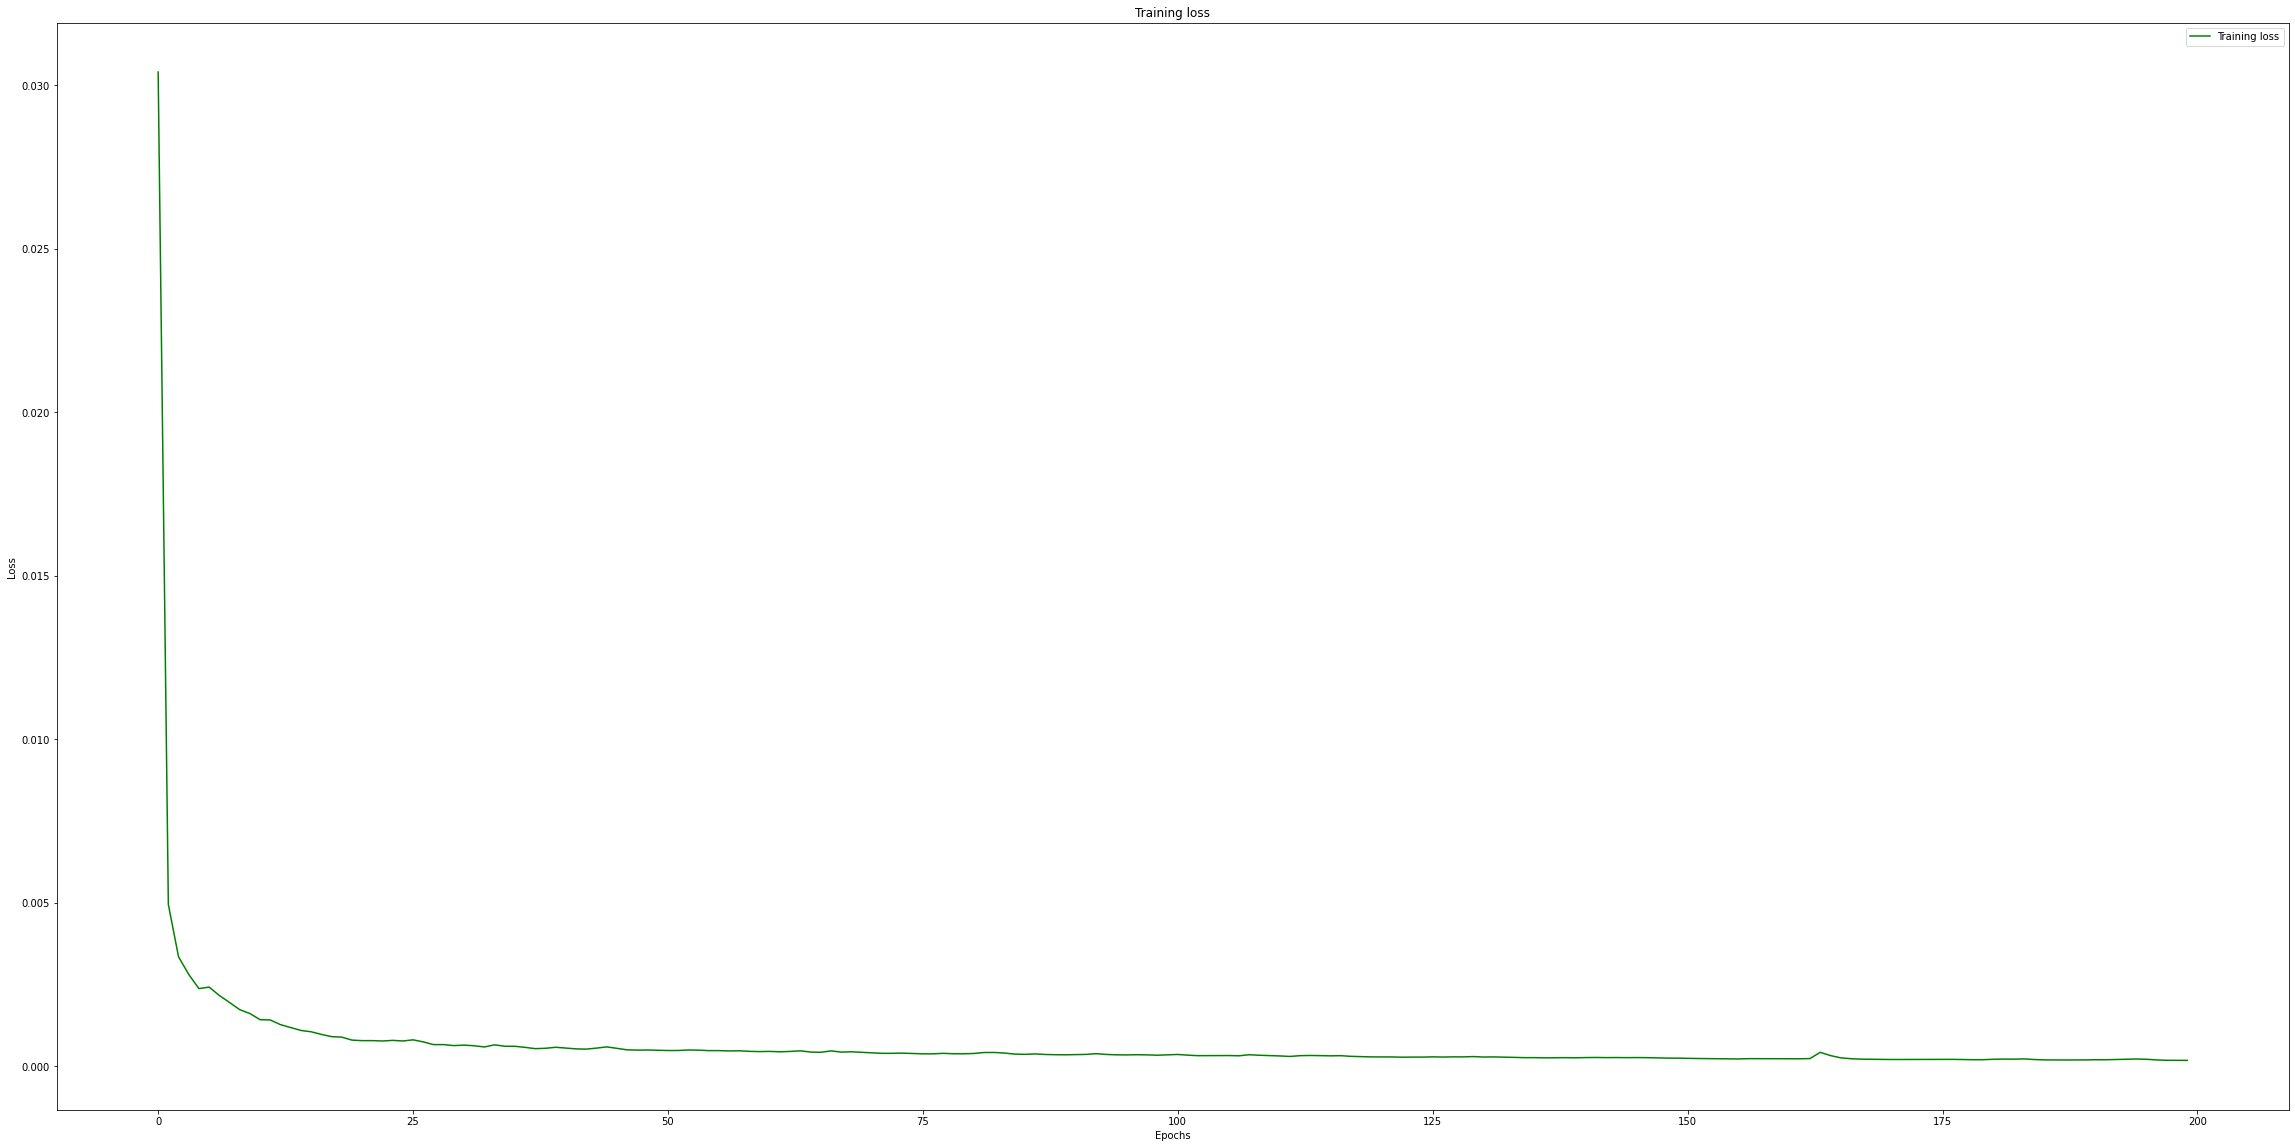

In [ ]:
#Plot the training and validation loss at each epoch
print(Unet_model_history.history)
loss = Unet_model_history.history['loss']

epochs = range(Epoch)
plt.figure(figsize=(40, 20))
plt.plot(epochs, loss, 'g', label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

{'loss': [0.03039800189435482, 0.0049501024186611176, 0.003348411526530981, 0.002810476114973426, 0.0023767496459186077, 0.002423804486170411, 0.0021673417650163174, 0.00195376412011683, 0.0017336151795461774, 0.001615033601410687, 0.0014272640692070127, 0.0014185580657795072, 0.0012753038899973035, 0.0011856965720653534, 0.0010984755354002118, 0.0010579201625660062, 0.0009775570360943675, 0.0009096190915443003, 0.0008944270084612072, 0.0008035743958316743, 0.0007868478423915803, 0.0007875000010244548, 0.0007754222024232149, 0.0007949611754156649, 0.0007764730253256857, 0.0008114236989058554, 0.0007483814842998981, 0.0006654999451711774, 0.0006657567573711276, 0.0006349491304717958, 0.0006494462722912431, 0.0006300971726886928, 0.0005934730870649219, 0.0006586555391550064, 0.0006148074171505868, 0.0006140659097582102, 0.0005809050053358078, 0.0005413523758761585, 0.0005535836098715663, 0.0005836711497977376, 0.0005586196202784777, 0.0005343272932805121, 0.0005277476157061756, 0.0005586

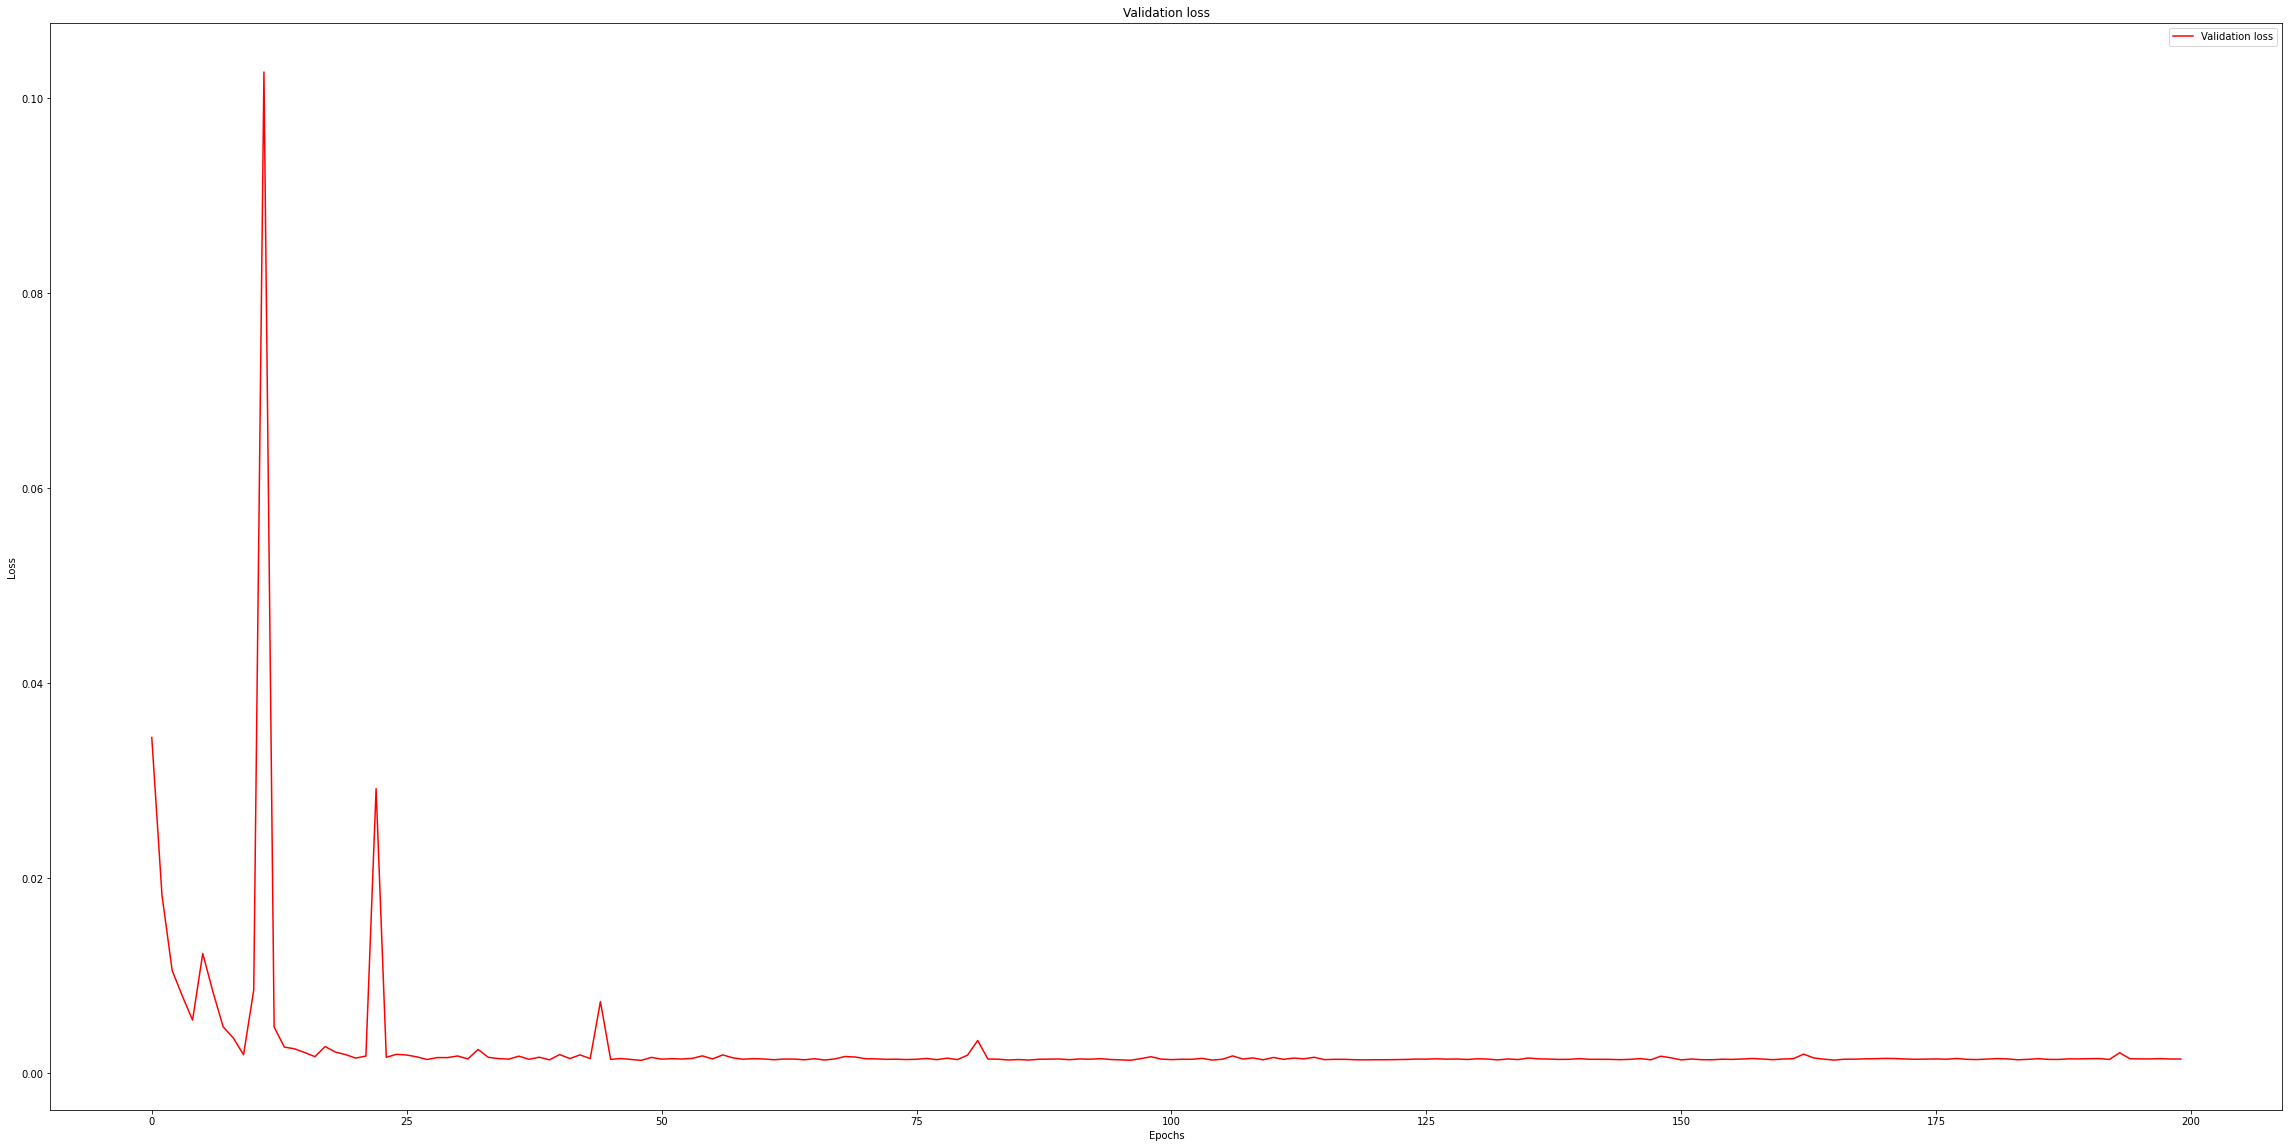

In [ ]:
#Plot the training and validation loss at each epoch
print(Unet_model_history.history)

val_loss = Unet_model_history.history['val_loss']
epochs = range(Epoch)
plt.figure(figsize=(40, 20))

plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Test the model

Unet_model_test = Unet.evaluate(validation_data, validation_mask, 
                                batch_size=1)

12/12 [==============================] - 0s 12ms/step - loss: 0.0014


In [ ]:
#Unet.save('Unet_12_24_22.h5')

In [ ]:
predict_train = Unet.predict(train_data)
predict_val = Unet.predict(validation_data)

1/1 [==============================] - 0s 44ms/step


In [ ]:
mse_train = np.mean((train_mask - predict_train) ** 2)
psnr_train = 10 * math.log10( 1 / mse_train)
print('MSE-Training:', mse_train)
print('Training Data PSNR: {psnr_train}dB'.format(psnr_train=np.round(psnr_train,2)))

mse_val = np.mean((validation_mask - predict_val) ** 2)
psnr_val = 10 * math.log10( 1 / mse_val)
print('MSE-Validation:', mse_val)
print('Validation Data PSNR: {psnr_val}dB'.format(psnr_val=np.round(psnr_val,2)))

MSE-Training: 0.0003485601
Training Data PSNR: 34.58dB
MSE-Validation: 0.0014352148
Validation Data PSNR: 28.43dB


Ground Truth:


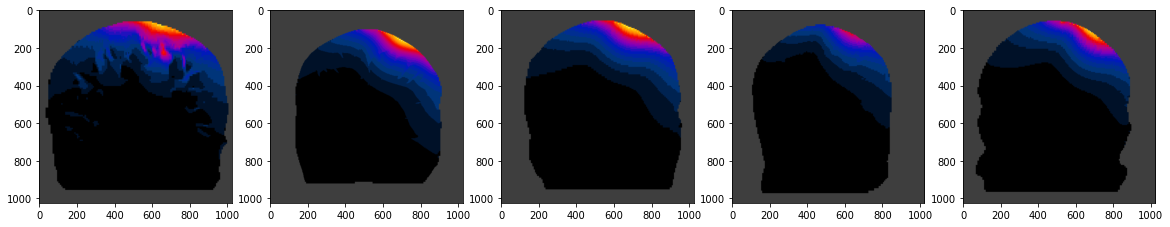

Prediction:


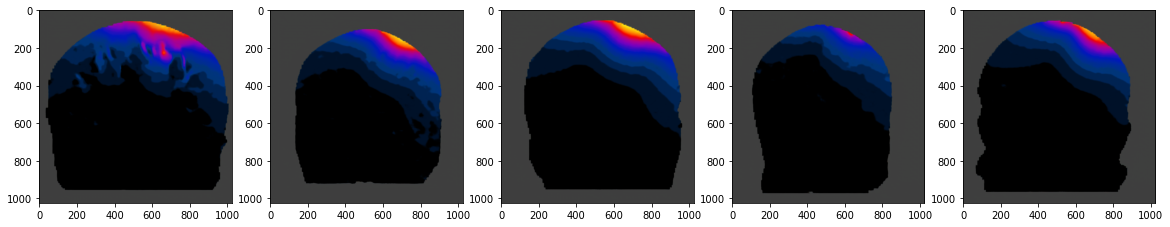

Ground Truth:


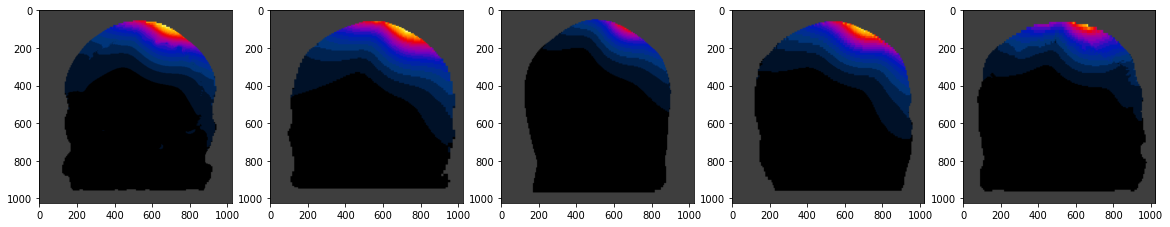

Prediction:


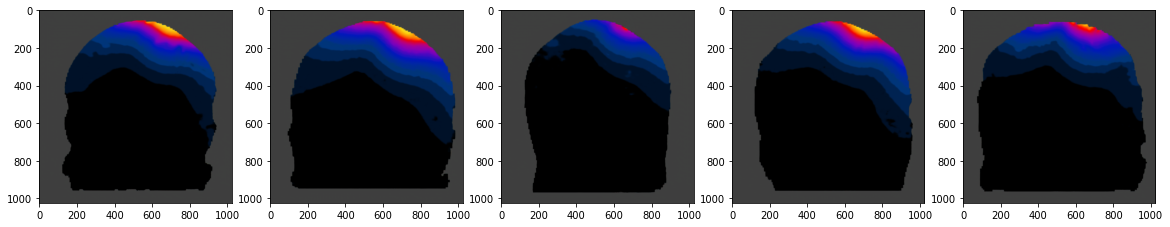

Ground Truth:


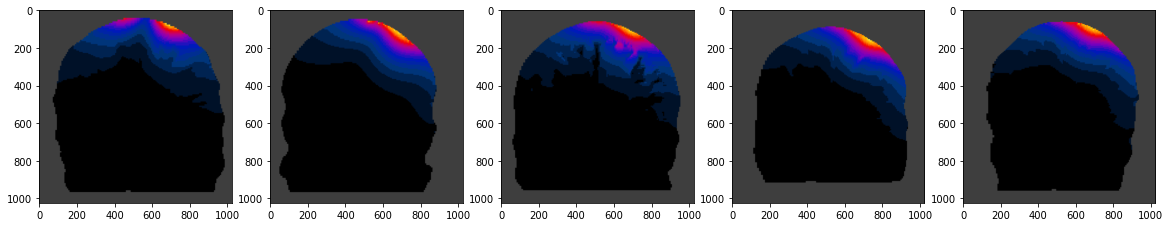

Prediction:


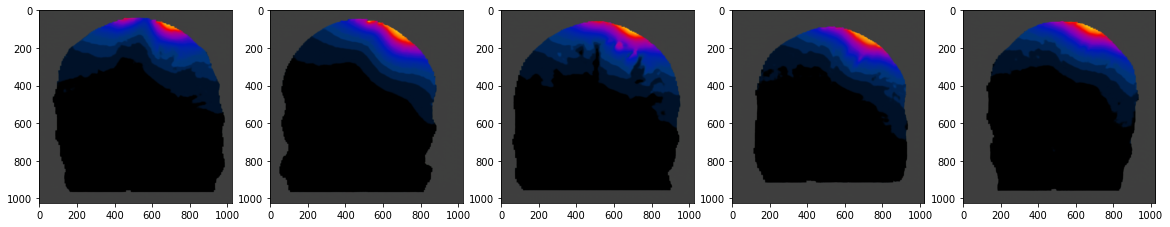

Ground Truth:


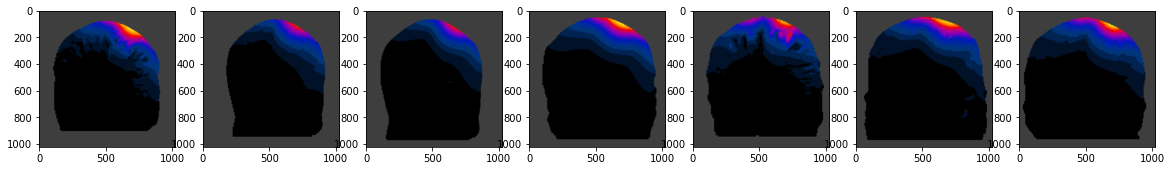

Prediction:


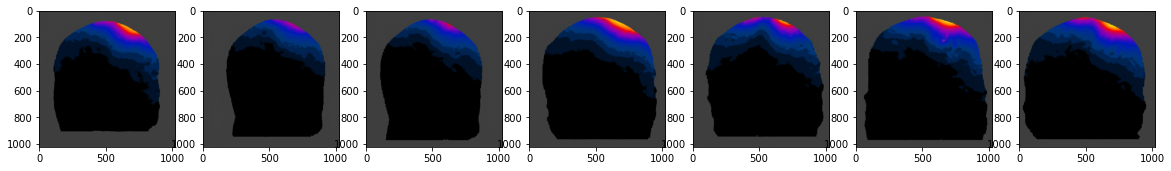

In [ ]:
plt.figure(figsize=(20, 10))
print("Ground Truth:")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(train_mask[i])
plt.show()

plt.figure(figsize=(20, 10))
print("Prediction:")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(predict_train[i])
plt.show()

plt.figure(figsize=(20, 10))
print("Ground Truth:")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(train_mask[i+5])
plt.show()

plt.figure(figsize=(20, 10))
print("Prediction:")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(predict_train[i+5])
plt.show()

plt.figure(figsize=(20, 10))
print("Ground Truth:")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(train_mask[i+10])
plt.show()

plt.figure(figsize=(20, 10))
print("Prediction:")
for i in range(5):
  plt.subplot(1, 5, i+1)
  plt.imshow(predict_train[i+10])
plt.show()

#plt.figure(figsize=(20, 10))
#print("Ground Truth:")
#for i in range(3):
#  plt.subplot(1, 3, i+1)
# plt.imshow(validation_mask[i])
#plt.show()

#plt.figure(figsize=(20, 10))
#print("Prediction:")
#for i in range(3):
#  plt.subplot(1, 3, i+1)
#  plt.imshow(predict_val[i])
#plt.show()

plt.figure(figsize=(20, 10))
print("Ground Truth:")
for i in range(7):
  plt.subplot(1, 7, i+1)
  plt.imshow(validation_mask[i])
plt.show()

plt.figure(figsize=(20, 10))
print("Prediction:")
for i in range(7):
  plt.subplot(1, 7, i+1)
  plt.imshow(predict_val[i])
plt.show()


In [ ]:
import plotly.graph_objects as go

Epochs = list(range(1, 201))

fig = go.Figure()
fig.add_trace(go.Scatter(x=Epochs, y=loss,
                    mode='lines+markers',
                    name='Training Loss'))
fig.add_trace(go.Scatter(x=Epochs, y=val_loss,
                    mode='lines+markers',
                    name='Validation Loss'))
fig.update_xaxes(title_text="Epochs")
fig.update_yaxes(title_text="Loss (MSE)")
fig.show()

In [ ]:
#import plotly.express as px

#fig = px.scatter(Epochs, loss)
#fig.show()